In [ ]:
import numpy as np                      # Data
import pandas as pd                     # Data 
import geopandas as gpd                 # Data
import xarray as xr                     # Data
import atlite                           # Model
import matplotlib.pyplot as plt         # Plot
from matplotlib.lines import Line2D     # Plot
from tqdm import tqdm                   # Visualise progression in loop
import yaml                             # Open yaml files

Load verification file

In [3]:
df_cf = pd.read_csv('../Data/verification_cf_wind_1423.csv',
                    index_col = 0,
                    parse_dates = True
)
df_cf

,EirGrid,Atlite,C3S National,C3S Gridded bilinear,C3S Gridded nearest
time,,,,,
2014-01-01 00:00:00,0.550839,0.535892,0.827359,0.862844,0.862949
2014-01-01 01:00:00,0.511257,0.487954,0.754657,0.781717,0.782512
2014-01-01 02:00:00,0.499598,0.479702,0.721853,0.767193,0.769097
2014-01-01 03:00:00,0.485817,0.481012,0.699896,0.768207,0.773429
2014-01-01 04:00:00,0.473917,0.478661,0.705907,0.762753,0.770112
...,...,...,...,...,...
2023-12-31 19:00:00,0.726874,0.730707,0.948785,0.953918,0.950913
2023-12-31 20:00:00,0.737899,0.739964,0.958814,0.972594,0.969898
2023-12-31 21:00:00,0.711651,0.737553,0.969503,0.989764,0.989536


In [9]:
df_turbines_ninja_030s = pd.read_csv('../Data/Wind Turbine Power Curves ~ 5 (0.01ms with 0.30 w smoother).csv')
turbine_enercon_smooth = {'hub_height':100,
                     'P':1.,
                     'V':df_turbines_ninja_030s['data$speed'].values,
                     'POW':df_turbines_ninja_030s['Enercon.E112.4500'].values
}

path_turbines_vestas = '../Data/power_curve_Vestas_V136_3450_c3se.yaml'
with open(path_turbines_vestas, 'r') as f:
    df_turbines_vestas = pd.json_normalize(yaml.safe_load(f))
    turbine_vestas = {'hub_height':100,
                      'P':1,
                      'V':np.array(df_turbines_vestas['V'].values[0]),
                      'POW':np.array(df_turbines_vestas['NPOW'].values[0])
    }

# Plots

In [7]:
bins = np.arange(-0.01, 1.01, 0.02)

KeyError: 'C3S-E G'

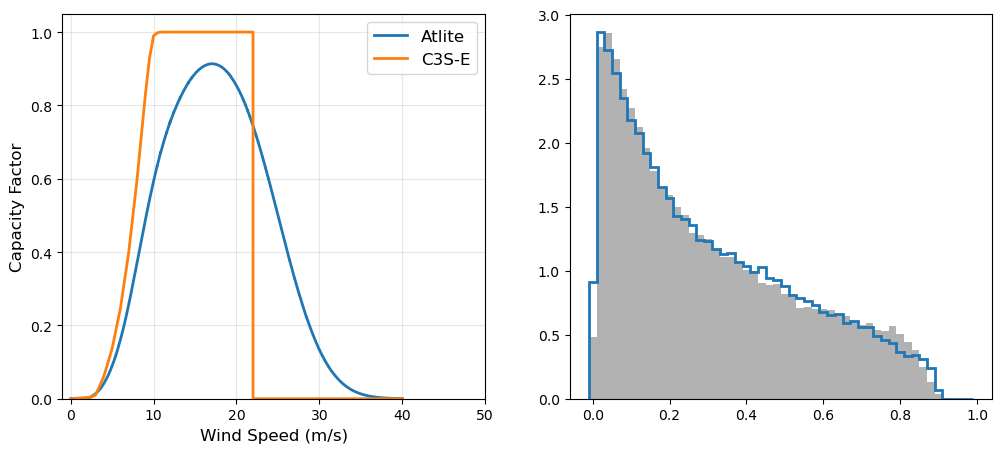

In [13]:
fig, ax = plt.subplots(1,2, figsize=(12,5))

# ax[0].set_title('Wind vs Power')
# ax[0].plot(turbine_ninja_nosmoothing['V'], turbine_ninja_nosmoothing['POW'], '--', color=colors[0], label='1. Enercon E112 4.5MW \n No Smoothing', lw=2.5)
ax[0].plot(turbine_enercon_smooth['V'], turbine_enercon_smooth['POW'], label='Atlite', lw=2, zorder=2)
ax[0].plot(turbine_vestas['V'], turbine_vestas['POW'], label='C3S-E', lw=2, zorder=2)
ax[0].set_xlim(-1,50)
ax[0].set_ylim(0)
ax[0].set_xlabel('Wind Speed (m/s)', color='k', fontsize=12)
ax[0].set_ylabel('Capacity Factor', color='k', fontsize=12)
ax[0].grid(alpha=0.3, zorder=0)
ax[0].legend(fontsize=12, ncol=1)


# ax[1].set_title('CF vs Freq')
hist_eirgrid, _, _ = ax[1].hist(df_cf['EirGrid'], bins=bins, 
                                density=True, color='k', 
                                alpha=0.3, zorder=1)
# hist_nosmooth, _, _ = ax[1].hist(cf_atlite_nosmooth, bins=bins, density=True, color=colors[0], label='A$_1$ = ', histtype='step', lw=2.5, zorder=3, ls='--')
hist_030smooth, _, _ = ax[1].hist(df_cf['Atlite'], bins=bins, 
                                  density=True, 
                                  histtype='step', lw=2, 
                                  zorder=3)
hist_vestas, _, _ = ax[1].hist(df_cf['C3S-E G'], bins=bins, 
                               density=True, 
                               histtype='step', lw=2, 
                               zorder=3, color='C1')
ax[1].set_xlabel('Capacity factor', color='k', fontsize=12)
ax[1].set_ylabel('Frequency of occurrence', color='k', fontsize=12)
ax[1].grid(alpha=0.3, zorder=0)
ax[1].set_xlim(-0.02, 1.02)
ax[1].set_ylim(0, 3.4)


total_area_030smooth = (abs(hist_030smooth - hist_eirgrid)*(bins[1:]-bins[:-1])).sum()
total_area_vestas = (abs(hist_vestas - hist_eirgrid)*(bins[1:]-bins[:-1])).sum()

custom_lines = [
    Line2D([0], [0], color='blue', lw=2),
    Line2D([0], [0], color='orange', lw=2)
]

label_leg = ['Atlite = {:.3f}'.format((abs(hist_030smooth - hist_eirgrid)*(bins[1:]-bins[:-1])).sum()),
              'C3S-E = {:.3f}'.format((abs(hist_vestas - hist_eirgrid)*(bins[1:]-bins[:-1])).sum())]

ax[1].legend(custom_lines, labels=label_leg, fontsize=12, title='Area', title_fontproperties={'weight':'bold', 'size':12})


ax[0].text(-0.1, 1.02, 'a/', fontsize=20, ha='left', va='top')
ax[1].text(0, 3.3, 'b/', fontsize=20, ha='left', va='top')

fig.tight_layout()
# fig.savefig('../../Figures/verification/Power_curve.png', dpi=300)
